<div class="alert alert-block alert-info">
    
# Hands Movements
## Renana Rimon
    
**target:** classify hand movements between two people into a spontanic, sync or alone state.

    
<div>

In [96]:
import os, cv2
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-info" role="alert">

## label explaination: <br>
**0 = spontanic <br>
1 = sync<br>
2 = alone**
<div>

<div class="alert alert-warning" role="alert">

### read function:
    
1. read csv
2. delete 7 first rows
3. delete spaces from columns
4. split df to half: right & left
5. enclose right hand to 'alone'
6. concat left & right to same row
7. take every 5th row
8. combine every 3 rows into one

<div>

In [4]:
# split df to half: right & left
def split(df) :
    half = int(len(df)/2)
    hd = df.head(half)
    tl = df.tail(len(df)-half)
    hd = hd.reset_index(drop=True)
    tl = tl.reset_index(drop=True)
    return hd, tl


In [5]:
# rename cols with L/R and num
def rename(df, char):
    for col in df.columns:
        col1 = char+col
        df = df.rename({col: col1}, axis=1)
    return df

In [6]:
#import HandRight
HandRight = pd.read_csv(r'HandRight.csv').iloc[8:,:]
for col in HandRight.columns:
    col1 = col.replace(" ", "_")
    HandRight = HandRight.rename({col: col1}, axis=1)
HandRight = HandRight.rename({'_#_hands': 'hands_num'}, axis=1) 
HandRight = HandRight[HandRight._Hand_Type == 'right']
HandRight = HandRight.dropna().reset_index(drop=True)

In [7]:
#combine every few rows into one
def combine(df,numOfRows):
    
    for i in range(1, numOfRows+1):
        line = ["{}{}".format(ind,'_'+str(i)) for ind in df.columns]
        if i==1:
            lineTotal = line
            lineArr = [line]
        else:
            lineTotal = lineTotal + line
            lineArr.append(line)

    headlines = pd.DataFrame(columns = lineTotal)

    
    for i in range(0, len(df)-len(df)%numOfRows, numOfRows):
    
        for j in range(0, numOfRows):
            listj = df.loc[i+j]
            listj.index = lineArr[j]
            if j==0:
                arr = [listj]
            else:
                arr.append(listj)
    
        jumpRows = pd.concat(arr)
        headlines = headlines.append(jumpRows, ignore_index = True)
        
    return headlines

In [ ]:
def read(path, num):
    df = pd.read_csv(path).iloc[8:,:]
        
    #delete spaces from columns
    for col in df.columns:
        col1 = col.replace(" ", "_")
        df = df.rename({col: col1}, axis=1)    
    df = df.rename({'_#_hands': 'hands_num'}, axis=1)  
    
    # 0/1 -> split 
    if(num != 2):
        df = df[df.hands_num == 2] # ensure hands_num is correct
        df = df.sort_values(by=['_Hand_Type'])
        left, right =split(df)
    
    
    # 2 -> enclose right hand
    else:
        left = df[df.hands_num == 1].reset_index(drop=True)
        right = HandRight.iloc[8:,:]
        if len(left)>len(right):
            right = right.append(right.iloc[8:(len(left)-len(right)+8),:]).reset_index(drop=True)
        else:
            right = right.iloc[:len(left),:]
    
    #concat left & right to same row
    left = rename(left, 'L')
    right = rename(right, 'R')
    df = pd.concat([left, right], axis=1)
    df = df.drop(['LTime', 'RTime', 'L_Frame_ID', 'R_Frame_ID', 'Lhands_num', 'Rhands_num'], axis=1)
    
    #take every 5th row
    df = df[df.index % 5 == 0].reset_index(drop=True)
    
    #combine every 3 rows into one
    df = combine(df,3)
    
    #label
    df['label']=num
    
    return df

<div class="alert alert-block alert-warning">

### import Train data
    
<div>

In [8]:
#evyatar
ev_spo = read(r'Evyatar636771052727603804Spontan.csv',0)
ev_sync = read(r'Evyatar636771053639929594Sync.csv',1)
ev_al = read(r'Evyatar636771054555711409Alone.csv',2)

In [9]:
#nofar
nofar_spo = read(r'Nofar636759795182793299Spontan.csv',0)
nofar_sync = read(r'Nofar636759797397919664Sync.csv',1)
nofar_al = read(r'Nofar636759796290435160Alone.csv',2)

In [10]:
#oriya
oriya_spo = read(r'Oriya636759804404113837Spontan.csv',0)
oriya_sync = read(r'Oriya636759806131350399Sync.csv',1)
oriya_al = read(r'Oriya636759805268396661Alone.csv',2)


In [11]:
#orya
orya_spo = read(r'OryaB636771083605535985Spontan.csv',0)
orya_sync = read(r'OryaB636771084494502229Sync.csv',1)
orya_al = read(r'OryaB636771082736601528Alone.csv',2)


In [12]:
#revital
rev_spo = read(r'Revital636770957038873193Spontan.csv',0)
rev_sync = read(r'Revital636770957894370062Sync.csv',1)
rev_al = read(r'Revital636770955999435879Alone.csv',2)


In [13]:
#sachar
sachar_spo = read(r'Sachar636771045591258071Spontan.csv',0)
sachar_sync = read(r'Sachar636771046527112972Sync.csv',1)
sachar_al = read(r'Sachar636771047408504303Alone.csv',2)


In [14]:
#shelly
shelly_spo = read(r'Shelly636759787508979097Spontan.csv',0)
shelly_sync = read(r'Shelly636759789526313406Sync.csv',1)
shelly_al = read(r'Shelly636759788383205274Alone.csv',2)


In [15]:
#yael
yael_spo = read(r'Yael636771059544754823Spontan.csv',0)
yael_sync = read(r'Yael636771060699529085Sync.csv',1)
yael_al = read(r'Yael636771061659067649Alone.csv',2)


In [16]:
#yoel
yoel_spo = read(r'Yoel636760921663075813Spontan.csv',0)
yoel_sync = read(r'Yoel636760923490742912Sync.csv',1)
yoel_al = read(r'Yoel636760922573364655Alone.csv',2)

In [129]:
dataFrames = [ev_spo, nofar_spo, oriya_spo, orya_spo,rev_spo, sachar_spo, shelly_spo, yael_spo, yoel_spo,
         ev_sync, nofar_sync, oriya_sync, orya_sync,rev_sync, sachar_sync, shelly_sync, yael_sync, yoel_sync,
         ev_al, nofar_al, oriya_al, orya_al,rev_al, sachar_al, shelly_al, yael_al, yoel_al ]

df = pd.concat(dataFrames)

In [130]:
# Hand_Type from string to int: left = 0, right = 1
def numeric(df):
    for col in df.columns:    
        if("Hand_Type" in col):
            if ("L" in col):
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(np.int64)
            else:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(1).astype(np.int64)

In [131]:
numeric(df)

In [132]:
df.isna().sum().sum()

126

In [133]:
# calcuate the precentage to understand the impact of the NaN on the data set
total_sum = df.isnull().sum().sort_values(ascending=False)
percentage = round((total_sum/df.isnull().count())*100, 3)
df1 = pd.concat([total_sum, percentage], axis=1, keys=['total_sum', 'percentage'])
df2 = df1[df1['total_sum']>0]
df2

,total_sum,percentage
R_Wrist_Pos_Y_2,2,0.027
L_Position_X_3,2,0.027
R_Position_Z_2,2,0.027
R_Velocity_X_2,2,0.027
R_Velocity_Y_2,2,0.027
...,...,...
L_Elbow_Pos_Z_2,1,0.013
L_Grab_Strenth_2,1,0.013
L_Grab_Angle_2,1,0.013
L_Pinch_Strength_2,1,0.013


In [135]:
df = df.dropna()

In [136]:
df.head()

,L_Hand_Type_1,L_Position_X_1,L_Position_Y_1,L_Position_Z_1,L_Velocity_X_1,L_Velocity_Y_1,L_Velocity_Z_1,L_Pitch_1,L_Roll_1,L_Yaw_1,...,R_Wrist_Pos_X_3,R_Wrist_Pos_Y_3,R_Wrist_Pos_Z_3,R_Elbow_pos_X_3,R_Elbow_Pos_Y_3,R_Elbow_Pos_Z_3,R_Grab_Strenth_3,R_Grab_Angle_3,R_Pinch_Strength_3,label
0,0,-102.09200,198.4801,36.821470,-143.442100,162.22250,138.81830,1.044945,0.220119,1.257915,...,205.1825,175.7701,14.586860,355.5135,38.01317,151.41010,0.0,0.000000,0.000000,0
1,0,-87.01425,181.4484,2.391368,0.267130,-39.35226,-14.64911,1.590843,0.713496,1.588960,...,149.3343,195.8305,18.134420,303.8842,50.75324,142.53030,0.0,0.600372,0.000000,0
2,0,-88.35677,117.5149,-1.507066,4.879696,-106.04380,30.13123,1.388725,0.532217,1.460566,...,165.8512,289.5272,23.289340,309.1972,101.78370,91.19925,0.0,0.454846,0.000000,0
3,0,-91.82849,187.9625,3.546683,-16.356640,-57.70452,-37.83114,1.616455,0.778057,1.621224,...,192.6499,207.2711,-2.155823,310.6127,30.43638,121.75680,0.0,0.908594,0.191551,0
4,0,-88.36761,185.6821,1.074904,9.990860,24.07274,-18.26352,1.561024,0.834355,1.560259,...,157.4693,267.7648,18.064220,309.6221,89.76556,92.71830,0.0,0.215488,0.000000,0


In [137]:
y = df['label']
X = df.drop(['label'], axis=1)

<div class="alert alert-block alert-warning">

### import Test data
    
<div>

In [69]:
#test
oded_sp = read(r'Oded636754670490266956Spontan.csv', 0)
oded_sync = read(r'Oded636754671560850581Sync.csv', 1)
oded_al = read(r'Oded636754669540564461Alone.csv',2)

it_sp = read(r'Itiel636770940701219076Spontan.csv', 0)
it_sync = read(r'Itiel636770941638547912Sync.csv', 1)
it_al = read(r'Itiel636770942529041679Alone.csv',2)

mor_sp = read(r'Mor636771064635567065Spontan.csv', 0)
mor_sync = read(r'Mor636771065531910215Sync.csv', 1)
mor_al = read(r'Mor636771066407626524Alone.csv',2)

In [87]:
dfs = [oded_sp, oded_sync, oded_al, it_sp, it_sync, it_al, mor_sp, mor_sync, mor_al]
df_test = pd.concat(dfs)
numeric(df_test)
df_test = df_test.dropna()

In [88]:
df_test.head()

,L_Hand_Type_1,L_Position_X_1,L_Position_Y_1,L_Position_Z_1,L_Velocity_X_1,L_Velocity_Y_1,L_Velocity_Z_1,L_Pitch_1,L_Roll_1,L_Yaw_1,...,R_Wrist_Pos_X_3,R_Wrist_Pos_Y_3,R_Wrist_Pos_Z_3,R_Elbow_pos_X_3,R_Elbow_Pos_Y_3,R_Elbow_Pos_Z_3,R_Grab_Strenth_3,R_Grab_Angle_3,R_Pinch_Strength_3,label
0,0,-134.93140,287.8021,57.69223,38.46176,-457.81310,-99.182950,0.926959,0.729198,0.596569,...,185.8083,195.3759,152.07010,395.0904,49.809700,91.72690,0.0,1.073817,0.0,0
1,0,-84.91040,289.5809,52.80002,20.60177,263.48830,8.594344,0.640838,0.432079,0.908195,...,197.1509,189.1245,116.83200,424.6440,62.880270,103.15460,0.0,0.428167,0.0,0
2,0,-145.93210,209.2152,36.66230,-48.71319,23.06279,146.699000,0.647866,0.784072,0.767953,...,217.0214,137.6736,112.52340,382.0355,-23.928400,234.72980,0.0,0.692063,0.0,0
3,0,-89.90157,362.7294,58.24301,-102.60660,397.61360,27.894090,0.809251,0.428544,0.860582,...,207.1271,183.4541,33.71537,373.2381,-15.743260,57.87835,0.0,0.610099,0.0,0
4,0,-126.69140,218.7554,14.62053,-35.02637,-189.79030,110.262100,0.351853,1.292042,0.754124,...,204.2352,175.7286,73.73287,385.2574,-4.826356,126.74020,0.0,0.712863,0.0,0


In [89]:
y_test_f = df_test['label']
X_test_f = df_test.drop(['label'], axis=1)

<div class="alert alert-block alert-warning">
    
## Selecting a Kernel and Tuning Hyperparameters
   1. scaling
   2. pca (n_components=15)
   3. GridSearch: find best parameters in each model
   4. compare models
    
**NOTE:** chosen n_components=15 because it is the lowest number of features that gives the best accuracy - 91%
    
<div>

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

pca = PCA(n_components=15)

X_reduced = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.3, random_state=42, shuffle = True)

Kfolds = StratifiedKFold(n_splits=5,shuffle=True, random_state=7)

In [124]:
model_params = {
    'random_forest':{
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 150],
            'max_depth': [10,20,50,80,100]
        }
    },
    
    'logistic_regression':{
        'model': LogisticRegression(multi_class= 'auto'),
        'params': {
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'C': [0.1, 0.5, 1.0]
        }
    },
    
    'xgb':{
        'model': XGBClassifier(eval_metric='mlogloss'),
        'params':{
            'n_estimators': [100, 150],
            'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]            
        }
    },
    
    'knn':{
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5,7,10, 15],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    }
}

In [125]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv = Kfolds, return_train_score= False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best score': clf.best_score_,
        'best params': clf.best_params_
    })

In [126]:
score_df = pd.DataFrame(scores)
score_df

,model,best score,best params
0,random_forest,0.798291,"{'max_depth': 100, 'n_estimators': 150}"
1,logistic_regression,0.739981,"{'C': 0.5, 'solver': 'liblinear'}"
2,xgb,0.803799,"{'learning_rate': 0.2, 'n_estimators': 150}"
3,knn,0.762393,"{'algorithm': 'auto', 'n_neighbors': 15}"


LR: 0.836771 (0.140428)
RF: 0.831857 (0.139469)
KNN: 0.634998 (0.260232)
xgb: 0.856452 (0.125357)


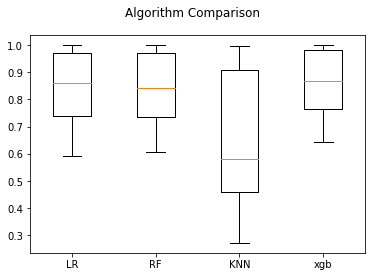

In [140]:
import matplotlib.pyplot as plt
from sklearn import model_selection

# prepare models
models = []
models.append(('LR', LogisticRegression(multi_class= 'auto', C=0.5, solver='liblinear')))
models.append(('RF', RandomForestClassifier(max_depth=20, n_estimators=150)))
models.append(('KNN', KNeighborsClassifier(algorithm='auto', n_neighbors=15)))
models.append(('xgb', XGBClassifier(eval_metric='mlogloss', learning_rate=0.1, n_estimators=150)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<div class="alert alert-danger" role="alert">
    
### NOTE: 
There may be differences in numerical accuracy,<br> so we will only consider the final result we will get on the test data.<br>
(the final results are better)
    
    
<div>

<div class="alert alert-block alert-warning">
    
### pipeLine: 
   * scale by StandardScaler
   * dimentionality reduction by PCA
   * fit
   * predict
   * score
    
**'Random Forest' and 'XGB' preformed best, so we will focus them**
    
<div>


In [73]:
def pipe(model):
    p = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=15)),
                ('mod', model)])
    p.fit(X, y)
    y_pred = p.predict(X_test_f)
    score = round(p.score(X_test_f, y_test_f),4)
    return y_pred, score

In [90]:
xgb = XGBClassifier(eval_metric='mlogloss',learning_rate = 0.1, n_estimators = 150)
y_pred_xgb, score_xgb = pipe(xgb)
score_xgb

0.9086

In [91]:
r_forest = RandomForestClassifier(max_depth=20, n_estimators= 150)
y_pred_forest, score_forest = pipe(r_forest)
score_forest

0.9068

In [94]:
#voting
pipeline = Pipeline([
    ('scaler1', StandardScaler()),
    ('pca1', PCA(n_components=15)),
    ('clf', VotingClassifier([
        ('rf', RandomForestClassifier(max_depth=20, n_estimators=150)),
        ('xgb', XGBClassifier(eval_metric='mlogloss', learning_rate=0.1, n_estimators=150))],voting='soft'))])

pipeline.fit(X, y)
y_pred_vote = pipeline.predict(X_test_f)
score_vote = round(pipeline.score(X_test_f, y_test_f),4)
score_vote

0.9122

In [95]:
#stacking
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=15)),
    ('stack', StackingClassifier([
        ('rf', RandomForestClassifier(max_depth=20, n_estimators=150)),            
        ('xgb', XGBClassifier(eval_metric='mlogloss',learning_rate = 0.1, n_estimators = 150))
        ]))])

pipeline.fit(X, y)
y_pred_stack = pipeline.predict(X_test_f)
round(pipeline.score(X_test_f, y_test_f),4)

0.9081

<div class="alert alert-block alert-warning">


## classification_report
### ~ best model: voting 91% ~

**Model Evaluation**
   * **Accuracy:** Overall, how often is the classifier correct? <br>
   $ Accuracy = \frac{(TP + TN)}{total} $
   * **f1 score:** The F1 score can be interpreted as a weighted average of the precision and recall [0-1].
   * **Precision:** When it predicts yes, how often is it correct?<br> 
   $ Precision = \frac {TP}{predicted T}$
   * **recall:** TP Rate(Sensitivity or Recall): When it’s actually yes, how often does it predict yes? <br>
   $ recall = \frac{TP}{TP+FP} $
    
<div>

In [97]:
report = classification_report(y_test_f, y_pred_vote, output_dict=True)
df_report = pd.DataFrame(report)
df_report

,0,1,2,accuracy,macro avg,weighted avg
precision,0.810056,0.965577,0.995851,0.912233,0.923828,0.922997
recall,0.975774,0.766393,0.994475,0.912233,0.912214,0.912233
f1-score,0.885226,0.854532,0.995162,0.912233,0.911640,0.911204
support,743.000000,732.000000,724.000000,0.912233,2199.000000,2199.000000


Text(0.5, 1.0, 'Confusion matrix voting\n')

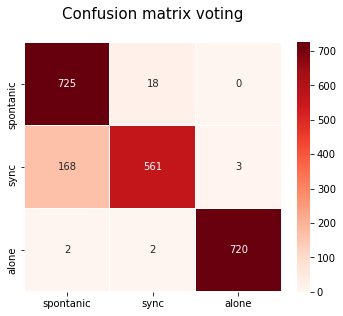

In [141]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(5,4))
cnf_matrix = confusion_matrix(y_test_f, y_pred_vote)

axis_labels = ['spontanic', 'sync', 'alone'] # labels for x-axis
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,cmap="Reds" , fmt='g', xticklabels=axis_labels, yticklabels=axis_labels, linewidths=0.1)

plt.tight_layout()
plt.title('Confusion matrix voting\n', fontsize=15)

<div class="alert alert-success" role="alert">


## conclusion:

*after dimensionality reduction with PCA, from **114** features to **15** features.*

### accuracy:

   * RandomForestClassifier: 90%
   * xgb: 90%
   * stacking: 90%
   * **voting: 91%**

**from f1-score (voting):** 
   * spontanic: 88.5% 
   * sync: 85.5% 
   * alone: 99.5% 
   
    
    
<div>